# Histograms of Color

Let's go back to our classification task: classifying images as day or night. You've looked at using raw pixel values to construct a brightness feature and now we'll look at histograms of pixel intensity (color histograms) as **feature vectors**.

Features can be arrays of useful values. Even the filtered images you've been creating are considered feature extracted images. Feature vectors are 1D arrays (or lists) of values, and they can be used when a single value is just not enough to classify an image.

In this notebook you'll see how to create a common type of feature vector: a **histogram**. A histogram is a graphical display of data that shows bars of different heights. Each bar groups data (in this case, pixel values) into ranges and the height of each bar indicates the number of times the data falls into that range. So, a taller bar show that more data falls in that specific range.

Let's see what an HSV color histogram looks like.

### Import resources

In [1]:
import cv2 # computer vision library

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

### Read in and standardize day and night images

We'll be analyzing two images: one day and one night from our training set of data; of the same scene. These have yet to be standardized, so they are resized to be the same.

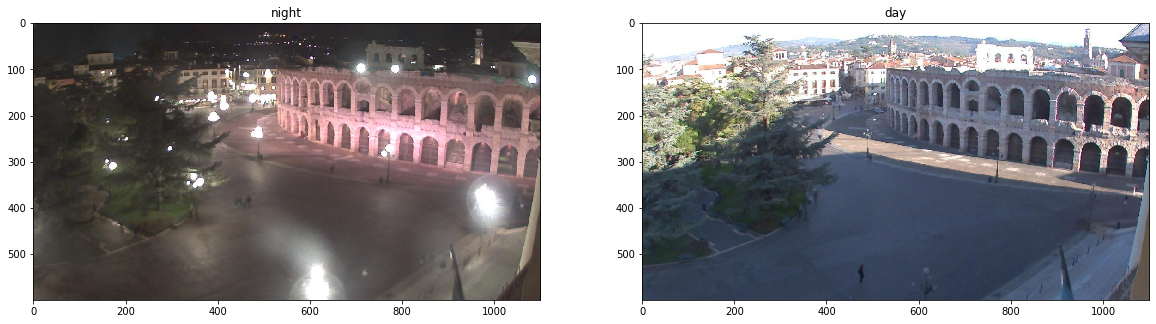

In [2]:
# Read in a day and a night image
# These are directly extracted by name -- do not change
day_image = mpimg.imread("day_night_images/training/day/20151102_074952.jpg")
night_image = mpimg.imread("day_night_images/training/night/20151102_175445.jpg")


# Make these images the same size
width = 1100
height = 600
night_image = cv2.resize(night_image, (width, height))
day_image = cv2.resize(day_image, (width, height))

# Visualize both images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('night')
ax1.imshow(night_image)
ax2.set_title('day')
ax2.imshow(day_image)

### Create HSV histograms

First, convert these images to HSV colorspace. Then use numpy's [histogram function](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html) to bin the color values into ranges. Bins are ranges of values like 0-15 for dark intensities or 200-255 for bright values.

With np.histogram(), you don't have to specify the number of bins or the range, but here I've arbitrarily chosen 32 bins and specified range=(0, 256) in order to get orderly bin sizes. np.histogram() returns a tuple of two arrays. In this case, for example, h_hist[0] contains the counts in each of the bins and h_hist[1] contains the bin edges (so it is one element longer than h_hist[0]).

To plot these results, we can compute the bin centers from the bin edges. Each of the histograms in this case have the same bins, so I'll just use the rhist bin edges: you can define the number of bins.

In [11]:
def hsv_histograms(rgb_image):
    # Convert to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Create color channel histograms
    h_hist = np.histogram(hsv[:,:,0], bins=32, range=(0, 180))
    s_hist = np.histogram(hsv[:,:,1], bins=32, range=(0, 256))
    v_hist = np.histogram(hsv[:,:,2], bins=32, range=(0, 256))
    
    # Generating bin centers
    bin_edges = h_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Plot a figure with all three histograms
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.bar(bin_centers, h_hist[0])
    plt.xlim(0, 180)    
    plt.title('H Histogram')
    
    plt.subplot(1,3,2)
    plt.bar(bin_centers, s_hist[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    
    plt.subplot(1,3,3)
    plt.bar(bin_centers, v_hist[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    
    return h_hist, s_hist, v_hist

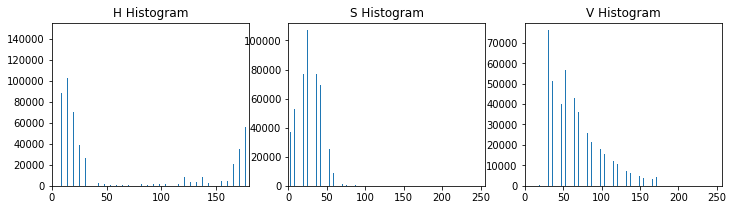

In [12]:
# Call the function for "night"
night_h_hist, night_s_hist, night_v_hist = hsv_histograms(night_image)


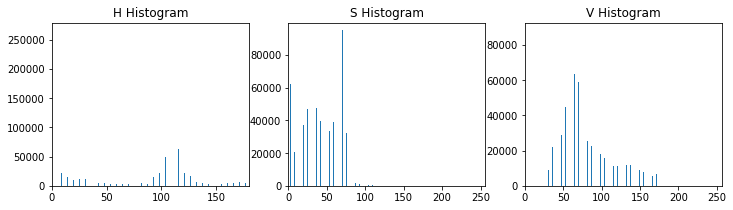

In [13]:
# Call the function for "day"
day_h_hist, day_s_hist, day_v_hist = hsv_histograms(day_image)

### Look at the differences

In [14]:
# Which bin do most V values fall in?
# Does the Hue channel look helpful?
# What patterns can you see that might distinguish these two images?

# Out of 32 bins, if the most common bin is in the middle or high up, then it's likely day
fullest_vbin_day = np.argmax(day_v_hist[0])
fullest_vbin_night = np.argmax(night_v_hist[0])


print('Fullest Value bin for day: ', fullest_vbin_day)
print('Fullest Value bin for night: ', fullest_vbin_night)

Fullest Value bin for day:  10
Fullest Value bin for night:  5


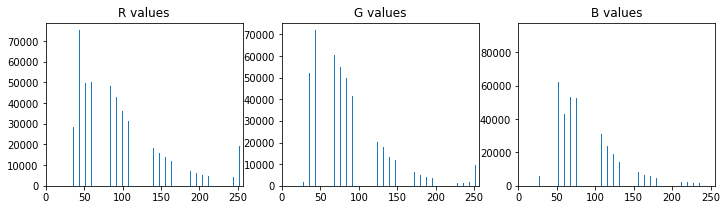

In [20]:
## TODO: Create and look at RGB histograms
# Practice what you've learned and look at RGB color histograms of these same images

def rgb_histograms(rgb_image):
    r_hist = np.histogram(rgb_image[:,:,0], bins=32, range=(0, 256))
    g_hist = np.histogram(rgb_image[:,:,1], bins=32, range=(0, 256))
    b_hist = np.histogram(rgb_image[:,:,2], bins=32, range=(0, 256))
    bin_edges = r_hist[1]
    bin_centers = (bin_edges[0:len(bin_edges)-1] + bin_edges[1:])/2
    fig = plt.figure(figsize = (12, 3))
    
    plt.subplot(1,3,1)
    plt.bar(bin_centers, r_hist[0])
    plt.xlim(0, 256)
    plt.title('R values')

    plt.subplot(1,3,2)
    plt.bar(bin_centers, g_hist[0])
    plt.xlim(0, 256)
    plt.title('G values')

    plt.subplot(1,3,3)
    plt.bar(bin_centers, b_hist[0])
    plt.xlim(0, 256)
    plt.title('B values')
    
    return r_hist, g_hist, b_hist

night_r_hist, night_g_hist, night_b_hist = rgb_histograms(night_image)

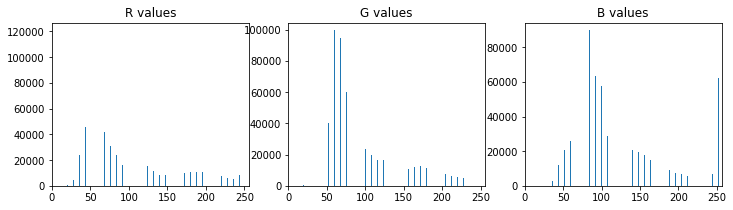

In [21]:
day_r_hist, day_g_hist, day_b_hist = rgb_histograms(day_image)

### Summations to create Feature Vectors

To keep spatial information, it is also a useful technique to sum up pixel values along the columns or rows of an image. This allows you to see spikes in varirous color values over space.

Let's look at the night image as an example; it's mostly dark but has a lot of little bright spots from artificial lights. I'll look at the Value component  in the image, sum up those pixel values along the columns using np.sum(), and I'll plot that summation.

### Sum the V component of the day image and compare the two

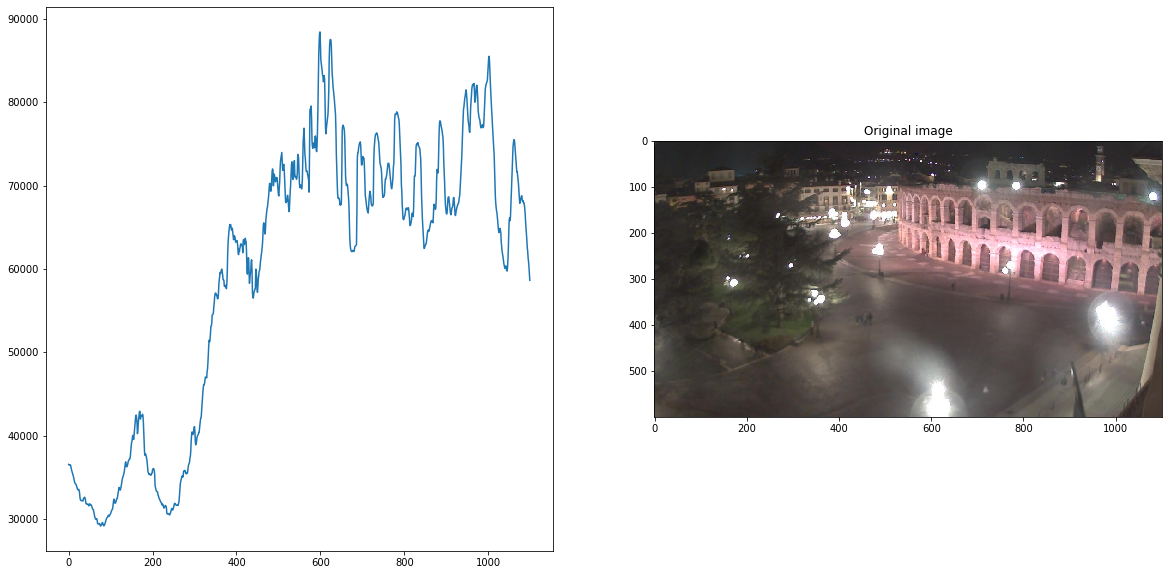

In [22]:
# Convert the night image to HSV colorspace
hsv_night = cv2.cvtColor(night_image, cv2.COLOR_RGB2HSV)

# Isolate the V component
v = hsv_night[:,:,2]

# Sum the V component over all columns (axis = 0)
v_sum = np.sum(v[:,:], axis=0)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax2.set_title('Value sum over columns')
ax1.plot(v_sum)

ax2.set_title('Original image')
ax2.imshow(night_image, cmap='gray')